Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 390 rows, 378 columns and 1560 nonzeros
Model fingerprint: 0x99c441b1
Variable types: 84 continuous, 294 integer (294 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 179.7639931
Presolve removed 342 rows and 222 columns
Presolve time: 0.00s
Presolved: 48 rows, 156 columns, 438 nonzeros
Variable types: 0 continuous, 156 integer (156 binary)

Root relaxation: cutoff, 66 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

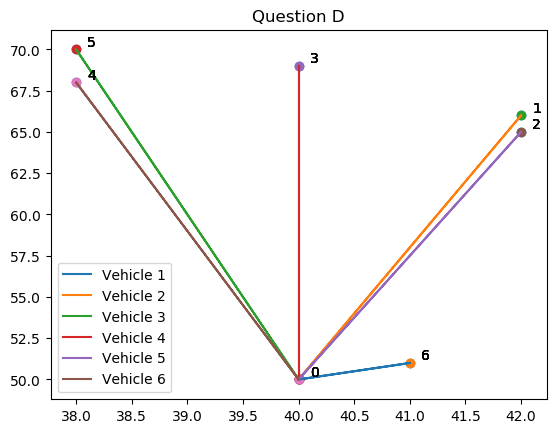

In [61]:
#Import packages
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

#Load the data
data_small = np.loadtxt("data_small.txt", dtype='i')
data_large = np.loadtxt("data_large.txt", dtype='i')


#Problem
model = Model('Assignment_2B')

# Parameters of the model
d = data_small
number_of_vehicles = 6
vehicle_capacity = 20

#Calculate Eucledian distance between the nodes
def c(i,j,data = d):
    distance = np.sqrt((d[i][1] - d[j][1]) ** 2 + (d[i][2] - d[j][2]) ** 2)
    return distance

X_COORD = []
for i in d[:,0]:
    X_COORD.append(d[i][1])
    
Y_COORD = []
for i in d[:,0]:
    Y_COORD.append(d[i][2])
    
D = []
for i in d[:,0]:
    D.append(d[i][3])
    
RT = []
for i in d[:,0]:
    RT.append(d[i][4])
    
DT = []
for i in d[:,0]:
    DT.append(d[i][5])
    
ST = []
for i in d[:,0]:
    ST.append(d[i][6])
    
# Sets

K = range(len(d))
V = range(number_of_vehicles)
M = 10000

# Variables

x = {}
for i in K:
    for j in K:
        for v in V:
            x[i,j, v] = model.addVar(vtype = GRB.BINARY, name = 'x['+str(i)+','+str(j)+ str(v) +']')
                
t = {}
for i in K:
    for v in V:
        t[i, v] = model.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 't['+str(i)+str(v) +',]')
        
z = {}
for i in K:
    for v in V:
        z[i, v] = model.addVar(vtype= GRB.CONTINUOUS, name = 'z['+str(i)+str(v) +',]')
    
model.update()

model.setObjective(quicksum(c(i,j) * x[i,j, v] for i in K for j in K for v in V))
model.modelSense = GRB.MINIMIZE
model.update()

# Constraints

# Constraint 1: A vehicle that enters the node should also leave it
con1 = {}
for i in K:
    for v in V:
        con1[i, v] = model.addConstr(quicksum(x[i,j,v] for j in K) == quicksum(x[j,i,v] for j in K))


# Constraint 2: A node should only be visited once
con2 = {}
for j in range(1, len(K)):
    con2[j] = model.addConstr(quicksum(x[i,j,v] for i in K for v in V) == 1)
    
# Constraint 3: A vehicle starts and ends its tour at point 0
con3 = {}
for v in V:
    con3[v] = model.addConstr(quicksum(x[0,j, v] for j in range(1,len(K))) == 1)

#Constraint 4: Implementation of due time
con4 = {}
for i in K:
    for v in V:
        con4[i, v] = model.addConstr(t[i, v] <= DT[i])
    
# Constraint 5: Imlementation of ready time
con5 = {}
for i in K:
    for v in V:
        con5[i, v] = model.addConstr(t[i, v] >= RT[i])
    
# Constraint 6: Implementation of service time
con6 = {}
for i in range(1,len(K)):
    for j in K:
        for v in V:
            con6[i,j, v] = model.addConstr(t[i, v] + ST[i] + c(i,j) - M*(1-x[i,j, v]) <= t[j, v])


            
model.update()

model.setParam('OutputFlag', True) 
model.setParam('MIPGap', 0);        
model.write("output.lp")

model.optimize ()


if model.status == GRB.Status.OPTIMAL:
        
    Loc_visited = [[] for v in V]
    Route = [[] for v in V]
    Time = [[] for v in V]
    Load = [[] for v in V]
    Route_xcoords = [[] for v in V]
    Route_ycoords = [[] for v in V]

    for v in V:
        for i in K:
            for j in K:
                if x[i,j,v].x == 1:
                    Loc_visited[v].append(j)

        z = 0
        while (len(Route[v]) < len(Loc_visited[v])+1):
            for i in K:
                for j in K:
                    if x[i,j,v].x == 1:
                        if (i in K) & (len(Route[v])==0):
                            Route[v].append(i)        
                        if (i == Route[v][-1]) & (j == Route[v][0]):
                            Route[v].append(j)  
                        if (i == Route[v][-1]) & (j not in Route[v]):
                            Route[v].append(j)

            z = z + 1
            if z > 500:
                print('Vehicle is not used in this problem')
                break
                
    for v in V:
        for w in Route[v]:
            Time[v].append(int(t[w, v].x))
            Time[v][0] = 0
    
    for v in V:
        for r in range(len(Route[v])):
            if r == 0:
                demand_route = 0
                for r in (Route[v]):
                    demand_route += D[r]
                Load[v].append(demand_route)
            else:
                Load[v].append(Load[v][r-1] - D[Route[v][r]])
        print('Vehicle:  ',v + 1,'\nRoute:    ',Route[v],'\nVeh Load: ',Load[v],'\n','\nTime of Arrival: ', Time[v])    
    
    print('Total distance travelled:     %.4f' % model.objVal)

# Plot
    
    origin_x = [X_COORD[0]]
    origin_y = [Y_COORD[0]]
    plt.style.use('default')

    for v in V:
        Route_xcoords[v] = [X_COORD[p] for p in Route[v]]
        Route_ycoords[v] = [Y_COORD[p] for p in Route[v]]
    
    for v in V:
        for p in K:
            if r == Route[v][0]:
                plt.annotate('Start/finish',(X_COORD[p], Y_COORD[p]), xytext=(X_COORD[p]+0.1, Y_COORD[p]+0.2))
            else:
                plt.annotate(p ,(X_COORD[p], Y_COORD[p]), xytext=(X_COORD[p]+0.1, Y_COORD[p]+0.2))

    plt.scatter(X_COORD, Y_COORD)
    
    for v in V:
        plt.scatter(Route_xcoords[v], Route_ycoords[v])
        plt.plot(Route_xcoords[v], Route_ycoords[v], label = f'Vehicle {v + 1}')
    
    plt.title('Question D')
    plt.legend(loc='lower left')
    plt.show()

else:
    print('\nNo feasible solution found')

In [ ]:
con7 = {}
for i in range(1, len(K)):
    con7[i] = model.addConstr(quicksum(z[i, v] for v in V) == 1)
    
con8 = model.addConstr(quicksum(z[0, v] for v in V) == number_of_vehicles)

con9 = {}
for v in V:
    con9[v] = model.addConstr(quicksum(D[i] * z[i, v] for i in K) <= vehicle_capacity)


con10 = {}
for i in K:
    for v in V:
        con10[i, v] = model.addConstr(quicksum(x[i,j,v] for j in K) == z[i,v])    
